In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io
import torchvision.transforms as transforms
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

/home/muzzi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 5
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [3]:
#type(train_loader)

#x, y = batch
#x, y = x.to(device), y.to(device)
#y_hat = model(x)

In [4]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

torch.Size([7, 49, 16])


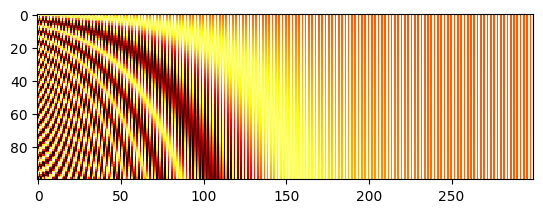

In [5]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [6]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [7]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out
MyViTBlock.forward

<function __main__.MyViTBlock.forward(self, x)>

In [8]:
MyViTBlock.forward

<function __main__.MyViTBlock.forward(self, x)>

In [8]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


In [9]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches) # [2,2]

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])# []
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output di

In [10]:
device = torch.device( "cpu")


In [11]:
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)


In [21]:
if __name__ == '__main__':
  model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)


  #x = torch.randn(7, 50, 8)  # Dummy sequences
  #print(model(x).shape)      # torch.Size([7, 50, 8])

In [12]:
model

MyViT(
  (linear_mapper): Linear(in_features=16, out_features=8, bias=True)
  (blocks): ModuleList(
    (0-1): 2 x MyViTBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (k_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (v_mappings): ModuleList(
          (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=8, out_features=32, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=32, out_features=8, bias=True)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=8, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [13]:
model.blocks.children

<bound method Module.children of ModuleList(
  (0-1): 2 x MyViTBlock(
    (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (mhsa): MyMSA(
      (q_mappings): ModuleList(
        (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
      )
      (k_mappings): ModuleList(
        (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
      )
      (v_mappings): ModuleList(
        (0-1): 2 x Linear(in_features=4, out_features=4, bias=True)
      )
      (softmax): Softmax(dim=-1)
    )
    (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=8, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=8, bias=True)
    )
  )
)>

In [14]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

1642


In [17]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=1024,num_workers=10)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=1024,num_workers=10)

    # Defining model and training options
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device( "cpu")
    #print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
    N_EPOCHS = 1
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        print("epoch", epoch)
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            #print("batch", batch)

            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)
            #print(batch)
            print("train_loss", loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)
            print("test_loss", loss)
            #print(batch)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

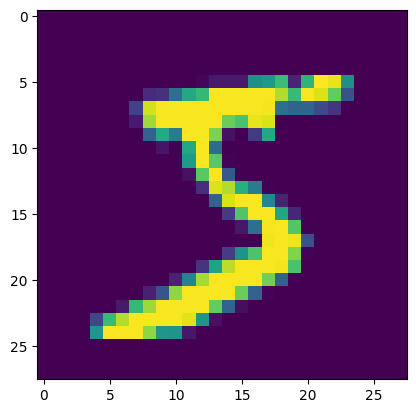

In [ ]:
#torch.distributed.init_process_group(backend="gloo")
#torch.set_num_interop_threads(10) # Inter-op parallelism
#torch.set_num_threads(10) 
main()

In [15]:
transform = ToTensor()
train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)


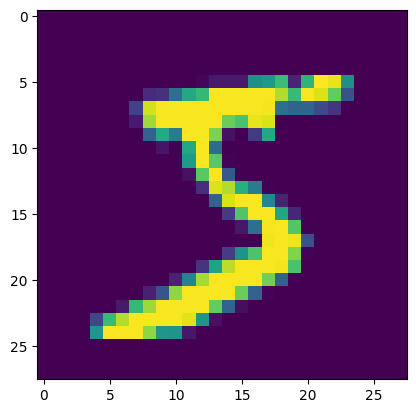

In [16]:
train_set.data.shape

plt.imshow(train_set.data[0])
plt.show()

In [63]:
### generate Mel spectrogram for phase data
path_to_files = f'/home/muzzi/pytorch mel classifier/phase data/'#120000850-144500850_Feb-02
import glob

import functions_ramsbrook_organisation
txtfiles = []
for file in glob.glob("/home/muzzi/pytorch mel classifier/phase data4///*.hdf5"):
    txtfiles.append(file)
time_interval = []
txtfiles.sort()
count = 0
Fs=10000

print("count", count)
count+=1
channel_range_start=0
channel_range_end = 3763
qtd = channel_range_end - channel_range_start

files = functions_ramsbrook_organisation.get_file_names(path_to_files)

phase_data = functions_ramsbrook_organisation.load_hdf5_file(path_to_files, files,
                                                                channels_to_load=[channel_range_start,
                                                                                channel_range_end], fs=Fs).reshape(
    (-1, qtd))



count 0
0 /home/muzzi/pytorch mel classifier/phase data/0000470390_2024-06-11_22.59.58.52288.hdf5
1 /home/muzzi/pytorch mel classifier/phase data/0000470391_2024-06-11_23.00.08.52288.hdf5
2 /home/muzzi/pytorch mel classifier/phase data/0000470392_2024-06-11_23.00.18.52288.hdf5
3 /home/muzzi/pytorch mel classifier/phase data/0000470393_2024-06-11_23.00.28.52288.hdf5
4 /home/muzzi/pytorch mel classifier/phase data/0000470394_2024-06-11_23.00.38.52288.hdf5
5 /home/muzzi/pytorch mel classifier/phase data/0000470395_2024-06-11_23.00.48.52288.hdf5
6 /home/muzzi/pytorch mel classifier/phase data/0000470396_2024-06-11_23.00.58.52288.hdf5
7 /home/muzzi/pytorch mel classifier/phase data/0000470397_2024-06-11_23.01.08.52288.hdf5
8 /home/muzzi/pytorch mel classifier/phase data/0000470398_2024-06-11_23.01.18.52288.hdf5
9 /home/muzzi/pytorch mel classifier/phase data/0000470399_2024-06-11_23.01.28.52288.hdf5


In [101]:
fft_output_leak_3636 = np.fft.fft2(phase_data[0:100000,3636-3:3636+3])
fft_output_leak_3636 = np.abs(fft_output_leak_3636)





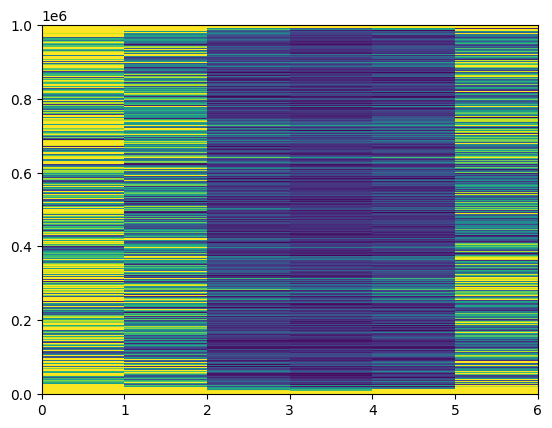

In [99]:
plt.pcolormesh(np.abs(fft_output_leak_3636),vmax=400)
plt.show()


In [94]:
fft_output_leak_3636.shape

(100000, 6)

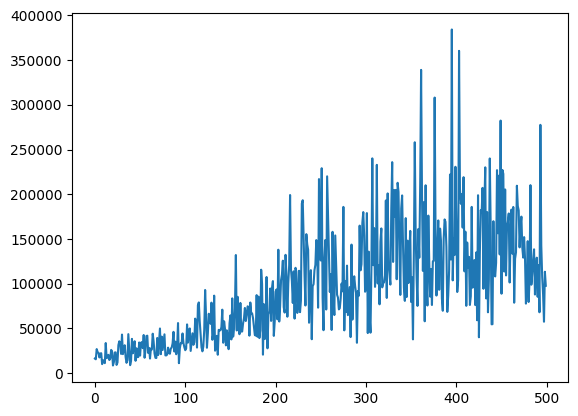

In [100]:
plt.plot(np.abs(fft_output_leak_3636[200:700,:]).sum(1))
plt.show()

In [76]:
fft_output_leak_3636

array([[ 4809.93966131,  9862.74609599,  8884.03184336, ...,
         8964.70122281,  8884.03184336,  9862.74609599],
       [ 4921.69120582, 10408.48677049,  9190.47119196, ...,
         8823.68038292,  8558.63315925,  9342.37133712],
       [ 4883.31879446, 10522.20138894,  9606.52137679, ...,
         8704.2360954 ,  8279.69102295,  9105.68931614],
       ...,
       [ 5668.68155791,  9200.88980343,  8311.67016398, ...,
         9085.48478549,  8951.15854253, 10727.68077473],
       [ 4883.31879446,  9105.68931614,  8279.69102295, ...,
         9446.77012768,  9606.52137679, 10522.20138894],
       [ 4921.69120582,  9342.37133712,  8558.63315925, ...,
         9184.23979447,  9190.47119196, 10408.48677049]])

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 6))
ax[0,0].hist(fft_output_leak_3636.ravel(), bins=100)
ax[0,0].set_title('hist(freq)')
ax[0,1].hist(np.log(fft_output_leak_3636).ravel(), bins=100)
ax[0,1].set_title('hist(log(freq))')
ax[1,0].imshow(np.log(fft_output_leak_3636), interpolation="none",aspect="auto")
ax[1,0].set_title('log(freq)')
ax[1,1].imshow(fft_output_leak_3636, interpolation="none",aspect="auto")
plt.show()



In [80]:
fft_output_no_leak_400 = np.fft.fft2(phase_data[0:10000,400-5,400+5])
plt.imshow(fft_output_no_leak_400)
plt.show()


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed